# Load libraries, define folders

Packages and data locations for analysis

In [1]:
import pandas as pd
import sys

segmentsToTarget = ['HA_vRNA','PB1_vRNA']
WSNfasta = 'Database/WSN_vRNA.fa'
scripts = 'Scripts'
sys.path.append(scripts)
import deletionLibrary
#an adapter in our mapping, remove from here
adapter = 'CCCTGAGACCAATA'
UPadd = 'CGTGTAGGCGATGGC'
DWNadd = 'ACTGCTTGCGATGAT'
junctionAdapter = 'Database/junctionSeqAdapter.fa'
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 12, 'axes.titlesize':'medium',})
import seaborn as sns
from string import ascii_uppercase
import glob
import numpy as np
import math
import os 
#same colors for the same segments throughout this paper. Use a colorblind-friendly palette
colormap = 'colorblind'
colors = sns.color_palette(colormap, 8)
#different order here as the 2nd and 4th colors of this palette are too similar
segments = ['PB1_vRNA','HA_vRNA','PB2_vRNA',  'PA_vRNA','NP_vRNA','NA_vRNA','M_vRNA','NS_vRNA']
fluColors = {}
for color, segment in enumerate(segments):
    fluColors[segment] = colors[color]
    
twoColorPalette = [sns.color_palette('colorblind',8)[-2],sns.color_palette('dark', 8)[-1]]
#for some light parallel processing
from multiprocessing import Pool

numProcessors = 4

# Generating primers for artificial libraries

Read in sequences for the generation of primers for artifical libraries.

In [2]:
sequences = {}
with open(WSNfasta, 'r') as infile:
    record = False
    for line in infile:
        if record:
            sequences[name] = line[:-len(adapter)-1]
            record = False
        if line[0] == '>':
            name = line[1:-1]
            if name in segmentsToTarget:
                record = True
                

Set desired intervals for artifical libraries. As it is believed that at least the first and last 100nt of vRNA are required for packaging, set the absolute limit to exclude the first, and last, 75nt. To generate a saturating amount in relevant sizes, divide the sequences into quarters, the first of which we will stagger primers at 25nt, then the next at 50nt, then the last half (50 percent of the gene) at 100nt. Check that all possible regions are identifiable by our strategy.

In [3]:
primerFrame = []
for sequence in sequences:
    intervals = int((len(sequences[sequence]) - 150)/4)
    staggerList = [(75, 75 + intervals, 25)]
    staggerList += [(75 + intervals, 75 + intervals *2, 50)]
    staggerList += [(intervals *2 + 75, len(sequences[sequence]) - 75, 100)]
    frame = deletionLibrary.makeDeletionPrimers(staggerList=staggerList, targetTemperature=60.0, oligoConcentration=0.0000005,
                                              sodiumConcentration = 0.05, targetSequence = sequences[sequence], minimumLength = 20)
    frame['orientation'] = 'UP'
    frame['segment'] = sequence
    primerFrame += [frame]
    frame = deletionLibrary.makeDeletionPrimers(staggerList=staggerList, targetTemperature=60.0, oligoConcentration=0.0000005,
                                              sodiumConcentration = 0.05, targetSequence = deletionLibrary.reverseComplement(sequences[sequence]), minimumLength = 20)
    frame['orientation'] = 'DOWN'
    frame['segment'] = sequence
    primerFrame += [frame]
primerFrame = pd.concat(primerFrame)
primerFrame['sequenceInRead'] = primerFrame.annealingSequence.str.slice(0,10,1)
primerFrame['occurrences'] = 1
uniqueFrame = primerFrame['occurrences'] = 1
uniqueFrame = primerFrame.groupby(['orientation', 'segment', 'sequenceInRead']).sum()
if len(uniqueFrame) == len(primerFrame):
    print('all junctions uniquely mappable')
uniqueFrame = uniqueFrame.reset_index().drop(columns=['occurrences', 'inferredMeltemp'])

all junctions uniquely mappable


What is the theoretical distribution of this library, if all PCR products have equal abundance, and all Gibson reactions occur equivalently?

(Sizes do not include 57nt adapter)

In [6]:
plotFrame = []
for segment in sequences.keys():
    sizes = []
    length = len(sequences[segment])
    for index, row in primerFrame[(primerFrame.segment == segment) & (primerFrame.orientation == 'UP')].iterrows():
        firstBases = row.position
        for index, row in primerFrame[(primerFrame.segment == segment) & (primerFrame.orientation == 'DOWN')].iterrows():
            plotFrame += [pd.DataFrame({'size':[firstBases + row.position - 1], 'segment':[segment]})]
plotFrame = pd.concat(plotFrame)
#convert to bins
binsize = 100
plotFrame['size'] = (plotFrame['size']/binsize).apply(np.ceil) * binsize
#convert to fraction of population, normalize area under the curve to 1 but don't want to use a KDE
plotFrame['count'] = 1
plotFrame = plotFrame.groupby(['segment', 'size']).sum().reset_index()
sums = plotFrame.groupby(['segment']).sum().reset_index().rename(columns={'count':'sum'}).drop(columns=['size'])
plotFrame = plotFrame.merge(sums, on = ['segment'] )
plotFrame['fraction'] = plotFrame['count']/plotFrame['sum']

bins = range(0, 4700,binsize)
g = sns.displot(data=plotFrame, x='size',  col="segment",  
               alpha=0.5,  bins= bins, weights='fraction', aspect= 1.2, height=4, hue='segment', hue_order = ["PB1_vRNA", "HA_vRNA"], facet_kws=dict(col_order=["PB1_vRNA", "HA_vRNA"]), palette=fluColors)
g.set_axis_labels("final size", "fraction of library")
g.set_titles("{col_name}")
plt.savefig('Figures/theoreticalDist.pdf', format='pdf', bbox_inches = "tight")





Need to add adapters to primer sequences

In [5]:
primerFrame['fullSequence'] = primerFrame.annealingSequence
primerFrame.loc[primerFrame.orientation == 'UP', 'fullSequence'] = UPadd + primerFrame[primerFrame.orientation == 'UP'].fullSequence
primerFrame.loc[primerFrame.orientation == 'DOWN','fullSequence'] = DWNadd + primerFrame[primerFrame.orientation == 'DOWN'].fullSequence


Export in a 384-well format for easy ordering.

In [41]:
primerFrame['Name'] = primerFrame['segment'] + '_' +  primerFrame['position'].astype(str) + '_' +  primerFrame.orientation
primerFrame['Well Position'] = ''
alphabet = list(ascii_uppercase)
maxWell = 24
#just make a list of all possible positions in order to pull from
wells = []
for character in alphabet:
    currNum = 1
    while currNum <= maxWell:
        wells += [character + str(currNum)]
        currNum += 1
wells = wells[:len(primerFrame)]
primerFrame['Well Position'] = wells
primerFrame = primerFrame.rename(columns = {'fullSequence':'Sequence'})
outPutFrame = primerFrame.loc[:,['Well Position', 'Name', 'Sequence']]
outPutFrame.to_csv('Results/PrimerDesign.tsv', sep='\t', index=False)

# Assignment of junctions to appropriate barcodes

Analyze junctions from all libraries, generate files. PB1 and HA libraries were submitted under the same indices as they are easy to disambiguate.

In [ ]:
filesToProcess = []
directory = 'Sequencing/barcodes/junctions/'
for file in glob.glob(directory + '*.gz'):
    seg = file.split('/')[-1].split('_')
    read = seg[-2]
    library = seg[-3].split('-')[-1]
    filesToProcess += [pd.DataFrame({'read':[read], 'library':[library], 'file':[file]})]
filesToProcess = pd.concat(filesToProcess)

def barcodeJunction(pandas):
    read1 = pandas[pandas.read == 'R1'].file.iloc[0]
    read1Unzip = read1[:-3]
    read2 = pandas[pandas.read == 'R2'].file.iloc[0]
    read2Unzip = read2[:-3]
    !gunzip -c $read1  > $read1Unzip
    !gunzip -c $read2  > $read2Unzip

    outFile = directory + 'library_' + str(pandas.library.iloc[0]) + '_junctions.tsv'
    deletionLibrary.junctionAssign(Read1=read1Unzip, Read2 = read2Unzip, UpMatch = 'GCCATCGCCTACACGACGCTTC',
                DownMatch = 'ATCATCGCAAGCAGTGGTCAACG',
                junctionLen=12, barcodeLen=12, outfile=outFile)
    !rm -f $read1Unzip
    !rm -f $read2Unzip



popList = set(filesToProcess.library)
while len(popList) > 0:
    with Pool(processes = numProcessors) as p:
        p.map(barcodeJunction, [filesToProcess[filesToProcess.library == popList.pop()] for i in range(numProcessors) if len(popList) != 0])



Collapse junctions, allow a hamming distance from junctions known to exist from our dataset by 1.

In [ ]:
def collapse(arguments):
      deletionLibrary.collapseJunctions(junctions=uniqueFrame, infile = arguments[0],
                                                outfile = arguments[1], permittedDistance=1)
directory = 'Sequencing/barcodes_V2/junctions/'
popList = []
for file in glob.glob(directory + '*_junctions.tsv'):
    outfile = '_'.join(file.split('_')[:-1]) + '_junctionsFixed.tsv'
    popList+= [(file, outfile)]


while len(popList) > 0:
    with Pool(processes = numProcessors) as p:
        p.map(collapse, [popList.pop() for i in range(numProcessors) if len(popList) != 0])

Assemble junctions. Highly abundant barcodes appeared to exhibit some low level of cross-contamination, likely attributable to PCR chimeras. Use an empirical threshold requiring 75% of reads to converge on a single answer. If an incorrect assumption this will bear out in comparing across libraries.


In [ ]:
directory = 'Sequencing/barcodes_V2/junctions/'
for file in glob.glob(directory + '*_junctionsFixed.tsv'):
    data = pd.read_csv(file, sep='\t')
    sums = data.groupby(['barcode','segment','orientation']).sum().reset_index()[['count','barcode','segment','orientation']].rename(columns={'count':'sum'})
    data = data.merge(sums, on=['barcode','segment','orientation'])
    data['ratio'] = data['count']/data['sum']
    data = data.loc[data.ratio >= 0.75]
    data = data[data.duplicated(subset=('barcode','segment'), keep=False)]
    data = data.loc[data.orientation == 'UP',].drop(['orientation', 'sum','ratio', 'Unnamed: 0'], axis=1).merge(
        data.loc[data.orientation=='DOWN'].drop(['orientation', 'sum','ratio', 'Unnamed: 0'], axis=1), on=['barcode', 'segment'], suffixes=['_UP','_DOWN'])
    outFile = '_'.join(file.split('_')[:-1]) + '_finalJunctions.tsv'
    data.to_csv(outFile, sep='\t', index=False)

Now just need to enumerate how frequently a barcode is observed in our sequencing datasets.

In [ ]:
def barcode(pandas):
    read1 = pandas[pandas.read == 'R1'].file.iloc[0]
    read1Unzip = read1[:-3]
    read2 = pandas[pandas.read == 'R2'].file.iloc[0]
    read2Unzip = read2[:-3]
    !gunzip -c $read1  > $read1Unzip
    !gunzip -c $read2  > $read2Unzip
    outFile = directory + 'library_' + str(pandas.library.iloc[0]) + '_barcodes.tsv'
    deletionLibrary.barcodeCount(Read1=read1Unzip, Read2 = read2Unzip, adjSeq = 'GTGCTCTTCCGGCCATCGCCTACACGACGCTTC',
                barcodeLen=12,  outfile=outFile)
    !rm -f $read1Unzip
    !rm -f $read2Unzip

folders = ['MACS_depleted', 'MACS_enriched', 'mingenome_no_polymerase', 'minigenome', 'plasmid', 'supernatant']
for folder in folders:
    filesToProcess = []
    directory = 'Sequencing/barcodes_V2/' + folder + '/'
    for file in glob.glob(directory + '*.gz'):
        seg = file.split('/')[-1].split('_')
        read = seg[-2]
        library = seg[-3].split('-')[-1]
        filesToProcess += [pd.DataFrame({'read':[read], 'library':[library], 'file':[file]})]
    filesToProcess = pd.concat(filesToProcess)



    popList = set(filesToProcess.library)
    while len(popList) > 0:
        with Pool(processes = numProcessors) as p:
            p.map(barcode, [filesToProcess[filesToProcess.library == popList.pop()] for i in range(numProcessors) if len(popList) != 0])



# Assembly statistics

First, lets load in all data from processing.

In [5]:
sequencing = {}
for folder in glob.glob('Sequencing/barcodes/*'):
    dataset = folder.split('/')[-1]
    sequencing[dataset] = []
    if folder.split('/')[-1] == 'junctions':
        for file in glob.glob(folder + '/*_finalJunctions.tsv'):  
            library = file.split('_')[-2]
            data = pd.read_csv(file, sep='\t')
            data['size'] = data.position_UP + data.position_DOWN 
            data['library'] = int(library)
            sequencing[dataset] += [data]
        
    else:
        for file in glob.glob(folder + '/*.tsv'):
            
            data = pd.read_csv(file, sep='\t')
            library = int(file.split('_')[-2][-1])
            segment = file.split('_')[-2][:-1]
            if segment ==  'H':
                segment = 'HA_vRNA'
            else:
                segment = 'PB1_vRNA'
            data['segment'] = segment
            data['library'] = library
            sequencing[dataset] += [data]
    sequencing[dataset] = pd.concat(sequencing[dataset])
freqCalled = []
for key in sequencing:
    if key != 'junctions':
        sequencing[key] = sequencing['junctions'].merge(sequencing[key], how='right', on = ['barcode', 'segment','library'] )
        numCounts = sequencing[key].groupby(['library', 'segment'])['count'].sum().reset_index().rename(columns = {'count':'total'})
        sequencing[key] = sequencing[key].dropna()
        numFinal = sequencing[key].groupby(['library','segment'])['count'].sum().reset_index()
        numCounts = numCounts.merge(numFinal, on=['library', 'segment'])
        numCounts['experiment'] = key
        freqCalled += [numCounts]
freqCalled = pd.concat(freqCalled)

What fraction of barcodes may be assigned to a junction? This is without using any kind of hamming function, or correction. Presumably that could increase fraction called, but if sufficient without doing so, we don't need to additionally see how ambiguous a barcode may be if we allow additional hamming distance. Alternatively, we may simply have failed to assemble all barcodes in our initial sequencing. Regardless, at around half of all barcodes assigned it appears that we can proceed as at best we would increase our calling by only 2-fold.

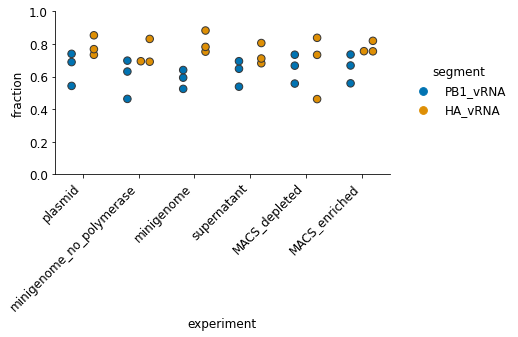

In [6]:
freqCalled['fraction'] = freqCalled['count']/freqCalled['total']
fig,ax = plt.subplots(figsize=(6,3))
order = ['plasmid', 'minigenome_no_polymerase', 'minigenome', 'supernatant', 'MACS_depleted', 'MACS_enriched']
sns.swarmplot(x="experiment", y="fraction", data=freqCalled, hue='segment', ax= ax, dodge=True, order = order, palette = fluColors,hue_order = ['PB1_vRNA', 'HA_vRNA'], s=7.5, linewidth=1)
sns.despine()
plt.ylim(0,1)
ax.legend(bbox_to_anchor=(1.05, 0.7), loc=2, borderaxespad=0.,frameon=False, title='segment')
a = plt.xticks(rotation=45, ha='right')
plt.savefig('Figures/fractionBarcodesAssembled.pdf', format='pdf', bbox_inches = "tight")


What fraction of our theoretical distribution of deletions are present in our initial plasmid library? Very high for PB1, and acceptable for HA.

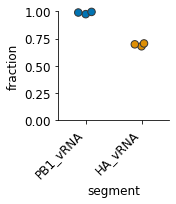

In [7]:
theoretical = []
fig,ax = plt.subplots(figsize=(2,2))

for segment in sequences.keys():
    sizes = []
    length = len(sequences[segment])
    for index, row in primerFrame[(primerFrame.segment == segment) & (primerFrame.orientation == 'UP')].iterrows():
        firstBases = row.position
        for index, row in primerFrame[(primerFrame.segment == segment) & (primerFrame.orientation == 'DOWN')].iterrows():
            theoretical += [pd.DataFrame({'position_UP':[firstBases ], 'position_DOWN':[row.position], 'segment':[segment]})]
theoretical = pd.concat(theoretical).groupby(['segment']).count().reset_index().rename(columns={'position_UP':'unique'}).drop(columns=['position_DOWN'])
uniquePlasmid = sequencing['plasmid'].groupby(['segment', 'position_UP', 'position_DOWN','library']).count().reset_index().groupby(['segment','library']).count().reset_index().merge(theoretical)
uniquePlasmid['fraction'] = uniquePlasmid['count']/uniquePlasmid.unique
sns.swarmplot(x="segment", y="fraction", data=uniquePlasmid, ax= ax, dodge=True, order = ['PB1_vRNA', 'HA_vRNA'], palette = fluColors, s=7.5, linewidth=1, clip_on=False)
sns.despine()
plt.ylim(0,1)
a = plt.xticks(rotation=45, ha='right')
plt.savefig('Figures/fractionInLibrary.pdf', format='pdf', bbox_inches = "tight")


How is the size of our plasmid library? Does it roughly match the theoretical? Leftward shift consistent with PCR bias. Still, sufficient to proceed. Data will be in supplement.

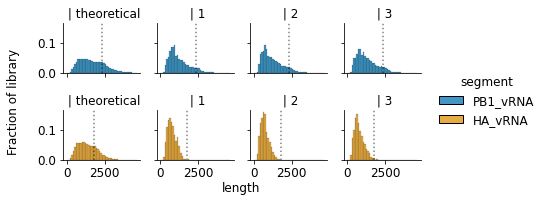

In [32]:
plas = sequencing['plasmid'].copy()
plas['size'] = (plas['size']/binsize).apply(np.ceil) * binsize
plas = plas.groupby(['size', 'segment', 'library']).sum().reset_index()[['size', 'segment', 'library', 'count']]
sums = plas.groupby(['segment','library']).sum().reset_index().rename(columns={'count':'sum'}).drop(columns=['size'])
plas = plas.merge(sums, on = ['segment','library'] )
plas['fraction'] = plas['count']/plas['sum']
plotFrame['library'] = 'theoretical'
plas = pd.concat([plas,plotFrame])
bins = range(0, 4700,binsize)

g = sns.displot(data=plas, x='size',  col="library",  row='segment',
                 bins= bins, weights='fraction', aspect=1, height=1.5, hue='segment', hue_order = ["PB1_vRNA", "HA_vRNA"], facet_kws=dict(row_order=["PB1_vRNA", "HA_vRNA"], col_order=['theoretical',1,2,3]),
                palette=fluColors)
g.set_axis_labels("", "")
g.set_titles(col_template="{col_name}", row_template="")

g.fig.text(0, 0.5, 'Fraction of library', va='center', rotation='vertical')
g.fig.text(0.4, 0.1, 'length', va='center')

for position, ax in enumerate(g.axes.flat):
    length = len(sequences[(["PB1_vRNA"]*4 +["HA_vRNA"]*4)[position]])
    ax.axvline(x=length, color='k', linestyle=':',alpha=0.5)

plt.savefig('Figures/actualandTheroeticalDist.pdf', format='pdf', bbox_inches = "tight")
plas = plas.loc[plas.library != 'theoretical',]
plas['sample'] = 'plasmid'
plt.savefig('Figures/theroeticalvsactualplasmid.pdf', format='pdf', bbox_inches = "tight")

# Selections

## Minigenome

The first selection we present to our library is a minigenome assay without polymerase. Protein expression constructs for NP, PB1, and PA were co-transfected with our libraries (at equal concentration), and samples harvested 24h post transfection. Populations shown are initial plasmid library and the resultant distribution after PolI transcription of viral RNA. For supplement. Further analysis of minigenome will use polI as a baseline.

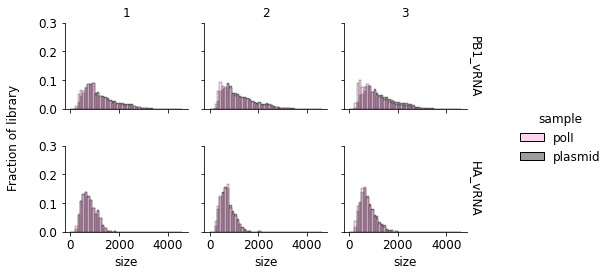

In [11]:
polI = sequencing['minigenome_no_polymerase'].copy()
polI['size'] = (polI['size']/binsize).apply(np.ceil) * binsize
polI = polI.groupby(['size', 'segment', 'library']).sum().reset_index()[['size', 'segment', 'library', 'count']]
sums = polI.groupby(['segment','library']).sum().reset_index().rename(columns={'count':'sum'}).drop(columns=['size'])
polI = polI.merge(sums, on = ['segment','library'] )
polI['fraction'] = polI['count']/polI['sum']
polI['sample'] = 'polI'
bins = range(0, 4700,binsize)
g = sns.displot(data=pd.concat([polI,plas]), x='size',  col="library", hue='sample',palette=twoColorPalette, row='segment',
               alpha=0.5, weights = 'fraction', bins= bins, aspect= 1.2, height=2,
               facet_kws=dict(row_order=["PB1_vRNA", "HA_vRNA"], col_order=[1,2,3], margin_titles=True))
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set(ylabel='fraction')

g.set(ylim=(0, 0.3))
g.set_axis_labels("size", " ")

g.fig.text(0.01, 0.5, 'Fraction of library', va='center', rotation='vertical')
plt.savefig('Figures/polIdistributionShift.pdf', format='pdf', bbox_inches = "tight")


Plot enrichment. Also supplement.

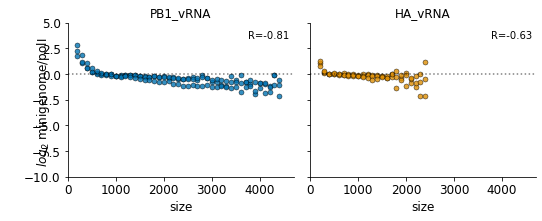

In [46]:
plas['sample'] = 'plasmid'

enrich = pd.concat([polI,plas]).pivot_table(index=['segment','size','library'], 
                                   columns=['sample'], values='fraction').reset_index().dropna()

counts = enrich.groupby(['segment', 'size']).count().reset_index()
counts = counts[counts.library == 3][['segment','size']]
enrich = enrich.merge(counts, on=['segment','size'], how='right')
enrich['enrichment'] = np.log2(enrich.polI/enrich.plasmid)


g = sns.lmplot(x="size", y="enrichment", col="segment", col_order=["PB1_vRNA", "HA_vRNA"], hue='segment', palette=fluColors,
               data=enrich, fit_reg=False,aspect=1.2, height=3,scatter_kws={"s":25, "linewidth":0.5,'edgecolor':'k'})
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set(ylabel="")


g.set_titles(col_template="{col_name}", row_template="{row_name}")


g.set_axis_labels("size", " ")

g.fig.text(0.01, 0.5, '$log_{2}$ minigenome/polI', va='center', rotation='vertical')

g.set(xlim=(0,4700))
g.set(ylim=(-10,5))

axes = g.fig.axes
for segment, ax in enumerate(axes):
    ax.axhline(y=0, color='k', linestyle=':',alpha=0.5)
    spearman = round(enrich[enrich.segment == ["PB1_vRNA", "HA_vRNA"][segment]].corr('spearman')['size']['enrichment'],2)
    ax.text(0.8, 0.9, 'R=' + str(spearman), transform=ax.transAxes, fontsize = 10)
plt.savefig('Figures/minigenomeEnrichmentBinned.pdf', format='pdf', bbox_inches = "tight")
enrich['library'] = enrich.library.astype(str)
enrich = enrich.pivot_table(index=['size','segment'], columns=['library'], values='enrichment').reset_index().dropna()
plt.savefig('Figures/polIGenomeenrichment.pdf', format='pdf', bbox_inches = "tight")

Same as above, but now PB2 has been included so the full viral polymerase is active. Corrected to PolI.

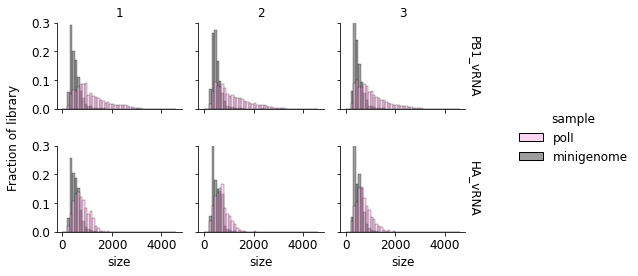

In [49]:
mini = sequencing['minigenome'].copy()
mini['size'] = (mini['size']/binsize).apply(np.ceil) * binsize
mini = mini.groupby(['size', 'segment', 'library']).sum().reset_index()[['size', 'segment', 'library', 'count']]
sums = mini.groupby(['segment','library']).sum().reset_index().rename(columns={'count':'sum'}).drop(columns=['size'])
mini = mini.merge(sums, on = ['segment','library'] )
mini['fraction'] = mini['count']/mini['sum']
mini['sample'] = 'minigenome'
bins = range(0, 4700,binsize)
g = sns.displot(data=pd.concat([polI,mini]), x='size',  col="library", hue='sample', row='segment',
               alpha=0.5, weights = 'fraction', bins= bins, aspect= 1.2, height=2, palette=twoColorPalette,
               facet_kws=dict(row_order=["PB1_vRNA", "HA_vRNA"], col_order=[1,2,3], margin_titles=True))
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set(ylim=(0, 0.3))

g.set_axis_labels("size", " ")

g.fig.text(0.01, 0.5, 'Fraction of library', va='center', rotation='vertical')
plt.savefig('Figures/minigenomePopulationShift.pdf', format='pdf', bbox_inches = "tight")

Plotting this enrichment

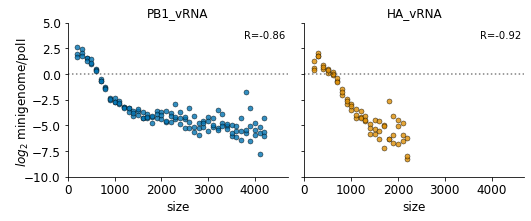

In [53]:
enrich = pd.concat([polI,mini]).pivot_table(index=['segment','size','library'], 
                                   columns=['sample'], values='fraction').reset_index().dropna()

counts = enrich.groupby(['segment', 'size']).count().reset_index()
counts = counts[counts.library == 3][['segment','size']]
enrich = enrich.merge(counts, on=['segment','size'], how='right')
enrich['enrichment'] = np.log2(enrich.minigenome/enrich.polI)


g = sns.lmplot(x="size", y="enrichment", col="segment", col_order=["PB1_vRNA", "HA_vRNA"], hue='segment', palette=fluColors,
               data=enrich, fit_reg=False,aspect=1.2, height=3,scatter_kws={"s":25, "linewidth":0.5,'edgecolor':'k'})
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set(ylabel="")


g.set_titles(col_template="{col_name}", row_template="{row_name}")


g.set_axis_labels("size", " ")

g.fig.text(-0.01, 0.5, '$log_{2}$ minigenome/polI', va='center', rotation='vertical')

g.set(xlim=(0,4700))
g.set(ylim=(-10,5))

axes = g.fig.axes
for segment, ax in enumerate(axes):
    ax.axhline(y=0, color='k', linestyle=':',alpha=0.5)
    spearman = round(enrich[enrich.segment == ["PB1_vRNA", "HA_vRNA"][segment]].corr('spearman')['size']['enrichment'],2)
    ax.text(0.8, 0.9, 'R=' + str(spearman), transform=ax.transAxes, fontsize = 10)

plt.savefig('Figures/minigenomeEnrichmentBinned.pdf', format='pdf', bbox_inches = "tight")
enrich['library'] = enrich.library.astype(str)
enrich = enrich.pivot_table(index=['size','segment'], columns=['library'], values='enrichment').reset_index().dropna()
plt.savefig('Figures/miniGenomeenrichment.pdf', format='pdf', bbox_inches = "tight")

Data highly repeatable even across individual junctions. Pearson correlation coefficient shown. Increased noise at highly depleted segments consistent with noise and rarer measurements.

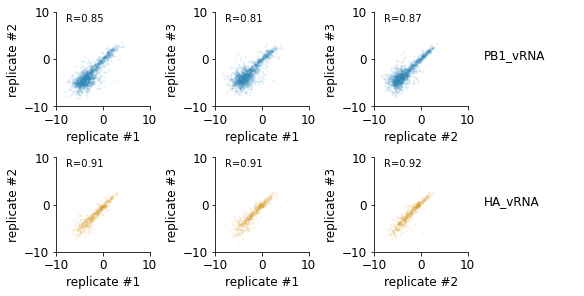

In [54]:
#combine barcodes into the same junction, but keep individual
polI_individual = sequencing['minigenome_no_polymerase'].copy().groupby(['segment','library','position_UP','position_DOWN','size']).sum().reset_index()[['segment','library','position_UP','position_DOWN','count','size']]
mini_individual = sequencing['minigenome'].copy().groupby(['segment','library','position_UP','position_DOWN','size']).sum().reset_index()[['segment','library','position_UP','position_DOWN','count','size']]
replicates = len(set(mini_individual.library))

sums = mini_individual.groupby(['segment','library']).sum().reset_index().rename(columns={'count':'sum'}).drop(columns=['size','position_UP','position_DOWN'])
mini_individual = mini_individual.merge(sums, on = ['segment','library'] )
mini_individual['fraction'] = mini_individual['count']/mini_individual['sum']

sums = polI_individual.groupby(['segment','library']).sum().reset_index().rename(columns={'count':'sum'}).drop(columns=['size','position_UP','position_DOWN'])
polI_individual = polI_individual.merge(sums, on = ['segment','library'] )
polI_individual['fraction'] = polI_individual['count']/polI_individual['sum']
#enrichment
enrichment = polI_individual.merge(mini_individual, on =['segment', 'library','position_UP','position_DOWN','size'], suffixes=['_polI','_mini'])
enrichment['enrichment'] = np.log2(enrichment.fraction_mini/enrichment.fraction_polI)
enrichment['library'] = enrichment.library.astype(str)
enrichment = enrichment.pivot_table(index=['position_UP','position_DOWN','segment'], columns=['library'], values='enrichment').reset_index().dropna().drop(columns=['position_UP','position_DOWN'])
columns = int(math.factorial(replicates)/(2* math.factorial(replicates-2)))
rows = len(set(enrichment.segment))
height = 2
width = 2
g= plt.figure(1,(width*(columns+1),rows*height), constrained_layout=True)

spec = g.add_gridspec(rows,columns +1)
for row, segment in enumerate(['PB1_vRNA','HA_vRNA']):
    numRep = 1
    currCol = 0
    first = False
    pearsonVal = enrichment[enrichment.segment == segment].corr()
    while numRep < replicates:
        comparison = numRep + 1
        
        while comparison <= replicates:
            if not first:
                ax = g.add_subplot(spec[row, currCol])
                firstAx = ax
                first = True
            else:
                ax = g.add_subplot(spec[row,currCol], sharey = firstAx, sharex= firstAx)
                
            sns.scatterplot(data=enrichment[enrichment.segment == segment], x=str(numRep), y=str(comparison),alpha=0.1, hue='segment', palette=fluColors,
                            legend=False, ax=ax, rasterized=True, s=5)
            sns.despine()
            ax.set_ylabel('replicate #' + str(comparison))
            ax.set_xlabel('replicate #' + str(numRep))
            ax.set_ylim(-10,10)
            ax.set_xlim(-10,10)
            Rval = round(pearsonVal[str(numRep)].iloc[comparison-1],2)
            ax.text(0.1, 0.9, 'R=' + str(Rval), transform=ax.transAxes, fontsize = 10)
            comparison += 1
            currCol +=1
        ax = g.add_subplot(spec[row, currCol])
        ax.axis('off')
        ax.text(0.0, 0.5, segment, transform=ax.transAxes, fontsize=12)
        numRep +=1
        
        
plt.savefig('Figures/minigenomeEnrichmentPearson.pdf', format='pdf', bbox_inches = "tight")


## Minigenome to supernatant

Cells were then infected at an MOI of 0.25 and infection was allowed to proceed for a full 72h. Supernatants were clarified by centrifugation and sequenced. How does the distribution change from the minigenome assay?

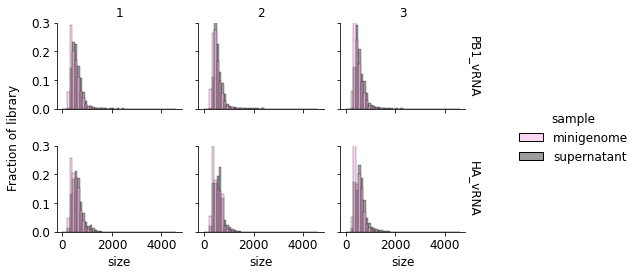

In [56]:
sup = sequencing['supernatant'].copy()
sup['size'] = (sup['size']/binsize).apply(np.ceil) * binsize
sup = sup.groupby(['size', 'segment', 'library']).sum().reset_index()[['size', 'segment', 'library', 'count']]
sums = sup.groupby(['segment','library']).sum().reset_index().rename(columns={'count':'sum'}).drop(columns=['size'])
sup = sup.merge(sums, on = ['segment','library'] )
sup['fraction'] = sup['count']/sup['sum']
sup['sample'] = 'supernatant'

bins = range(0, 4700,binsize)
g = sns.displot(data=pd.concat([mini,sup]), x='size',  col="library", hue='sample', row='segment',
               alpha=0.5, weights = 'fraction', bins= bins, aspect= 1.2, height=2, palette=twoColorPalette,
               facet_kws=dict(row_order=["PB1_vRNA", "HA_vRNA"], col_order=[1,2,3], margin_titles=True))
g.set_titles(col_template="{col_name}", row_template="{row_name}")

g.set(ylim=(0, 0.3))
g.set_axis_labels("size", " ")

g.fig.text(0.01, 0.5, 'Fraction of library', va='center', rotation='vertical')
plt.savefig('Figures/supernatantPopulationShift.pdf', format='pdf', bbox_inches = "tight")

Again, plot enrichment as a function of size

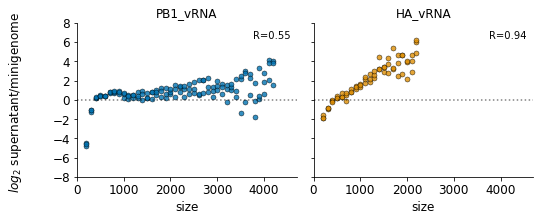

In [61]:
enrich = pd.concat([sup,mini]).pivot_table(index=['segment','size','library'], 
                                   columns=['sample'], values='fraction').reset_index().dropna()

counts = enrich.groupby(['segment', 'size']).count().reset_index()
counts = counts[counts.library == 3][['segment','size']]
enrich = enrich.merge(counts, on=['segment','size'], how='right')
enrich['enrichment'] = np.log2(enrich.supernatant/enrich.minigenome)


g = sns.lmplot(x="size", y="enrichment", col="segment", col_order=["PB1_vRNA", "HA_vRNA"], hue='segment', palette=fluColors,
               data=enrich, fit_reg=False,aspect=1.2,height=3,scatter_kws={"s":25, "linewidth":0.5,'edgecolor':'k'})
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set(ylabel="")


g.set_titles(col_template="{col_name}", row_template="{row_name}")


g.set_axis_labels("size", " ")

g.fig.text(-0.04, 0.5, '$log_{2}$ supernatant/minigenome', va='center', rotation='vertical')

g.set(xlim=(0,4700))
g.set(ylim=(-8,8))
g.set(yticks=np.arange(-8, 10, step=2))
axes = g.fig.axes
for segment, ax in enumerate(axes):
    ax.axhline(y=0, color='k', linestyle=':',alpha=0.5)
    spearman = round(enrich[enrich.segment == ["PB1_vRNA", "HA_vRNA"][segment]].corr('spearman')['size']['enrichment'],2)
    ax.text(0.8, 0.9, 'R=' + str(spearman), transform=ax.transAxes, fontsize = 10)
plt.savefig('Figures/SupernatantEnrichmentBinned.pdf', format='pdf', bbox_inches = "tight")
enrich['library'] = enrich.library.astype(str)
enrich = enrich.pivot_table(index=['size','segment'], columns=['library'], values='enrichment').reset_index().dropna()
plt.savefig('Figures/supernatantEnrichment.pdf', format='pdf', bbox_inches = "tight")

Again, to confirm strength of results look at Pearson coefficient between replicates for individual junctions. For PB1 correlations are worse as there simply isn't a strong effect size for most junctions.

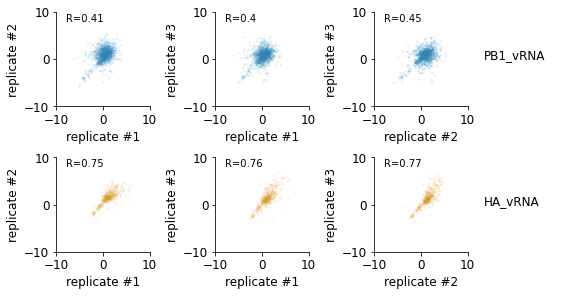

In [62]:
#combine barcodes into the same junction, but keep individual
sup_individual = sequencing['supernatant'].copy().groupby(['segment','library','position_UP','position_DOWN','size']).sum().reset_index()[['segment','library','position_UP','position_DOWN','count','size']]
mini_individual = sequencing['minigenome'].copy().groupby(['segment','library','position_UP','position_DOWN','size']).sum().reset_index()[['segment','library','position_UP','position_DOWN','count','size']]
replicates = len(set(mini_individual.library))

sums = mini_individual.groupby(['segment','library']).sum().reset_index().rename(columns={'count':'sum'}).drop(columns=['size','position_UP','position_DOWN'])
mini_individual = mini_individual.merge(sums, on = ['segment','library'] )
mini_individual['fraction'] = mini_individual['count']/mini_individual['sum']

sums = sup_individual.groupby(['segment','library']).sum().reset_index().rename(columns={'count':'sum'}).drop(columns=['size','position_UP','position_DOWN'])
sup_individual = sup_individual.merge(sums, on = ['segment','library'] )
sup_individual['fraction'] = sup_individual['count']/sup_individual['sum']
#enrichment
enrichment = sup_individual.merge(mini_individual, on =['segment', 'library','position_UP','position_DOWN','size'], suffixes=['_sup','_mini'])
enrichment['enrichment'] = np.log2(enrichment.fraction_sup/enrichment.fraction_mini)
enrichment['library'] = enrichment.library.astype(str)
enrichment = enrichment.pivot_table(index=['position_UP','position_DOWN','segment'], columns=['library'], values='enrichment').reset_index().dropna().drop(columns=['position_UP','position_DOWN'])
columns = int(math.factorial(replicates)/(2* math.factorial(replicates-2)))
rows = len(set(enrichment.segment))
height = 2
width = 2
g= plt.figure(1,(width*(columns+1),rows*height), constrained_layout=True)

spec = g.add_gridspec(rows,columns +1)
for row, segment in enumerate(['PB1_vRNA','HA_vRNA']):
    numRep = 1
    currCol = 0
    first = False
    pearsonVal = enrichment[enrichment.segment == segment].corr()
    while numRep < replicates:
        comparison = numRep + 1
        
        while comparison <= replicates:
            if not first:
                ax = g.add_subplot(spec[row, currCol])
                firstAx = ax
                first = True
            else:
                ax = g.add_subplot(spec[row,currCol], sharey = firstAx, sharex= firstAx)
                
            sns.scatterplot(data=enrichment[enrichment.segment == segment], x=str(numRep), y=str(comparison), alpha=0.1, hue='segment', palette=fluColors,
                            legend=False, ax=ax, rasterized=True, s=5)
            sns.despine()
            ax.set_ylabel('replicate #' + str(comparison))
            ax.set_xlabel('replicate #' + str(numRep))
            ax.set_ylim(-10,10)
            ax.set_xlim(-10,10)
            Rval = round(pearsonVal[str(numRep)].iloc[comparison-1],2)
            ax.text(0.1, 0.9, 'R=' + str(Rval), transform=ax.transAxes, fontsize = 10)
            comparison += 1
            currCol +=1
        ax = g.add_subplot(spec[row, currCol])
        ax.axis('off')
        ax.text(0.0, 0.5, segment, transform=ax.transAxes, fontsize=12)
        numRep +=1
        
        
plt.savefig('Figures/supernatantEnrichmentPearson.pdf', format='pdf', bbox_inches = "tight")


The coefficient is a little mediocre for PB1, what if we restrict to just lengths less than or equal to 1000bp?

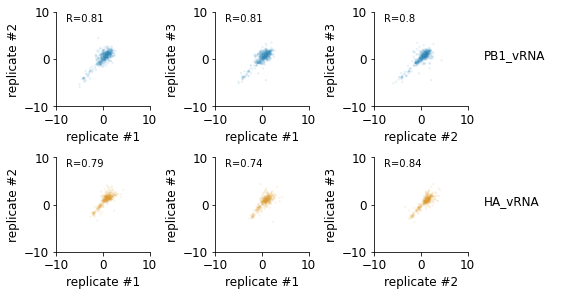

In [63]:
#combine barcodes into the same junction, but keep individual
sup_individual = sequencing['supernatant'].copy().groupby(['segment','library','position_UP','position_DOWN','size']).sum().reset_index()[['segment','library','position_UP','position_DOWN','count','size']]
mini_individual = sequencing['minigenome'].copy().groupby(['segment','library','position_UP','position_DOWN','size']).sum().reset_index()[['segment','library','position_UP','position_DOWN','count','size']]
replicates = len(set(mini_individual.library))

sums = mini_individual.groupby(['segment','library']).sum().reset_index().rename(columns={'count':'sum'}).drop(columns=['size','position_UP','position_DOWN'])
mini_individual = mini_individual.merge(sums, on = ['segment','library'] )
mini_individual['fraction'] = mini_individual['count']/mini_individual['sum']

sums = sup_individual.groupby(['segment','library']).sum().reset_index().rename(columns={'count':'sum'}).drop(columns=['size','position_UP','position_DOWN'])
sup_individual = sup_individual.merge(sums, on = ['segment','library'] )
sup_individual['fraction'] = sup_individual['count']/sup_individual['sum']
#enrichment
enrichment = sup_individual.merge(mini_individual, on =['segment', 'library','position_UP','position_DOWN','size'], suffixes=['_sup','_mini'])
enrichment = enrichment.loc[enrichment['size'] < 1000]
enrichment['enrichment'] = np.log2(enrichment.fraction_sup/enrichment.fraction_mini)
enrichment['library'] = enrichment.library.astype(str)
enrichment = enrichment.pivot_table(index=['position_UP','position_DOWN','segment'], columns=['library'], values='enrichment').reset_index().dropna().drop(columns=['position_UP','position_DOWN'])
columns = int(math.factorial(replicates)/(2* math.factorial(replicates-2)))
rows = len(set(enrichment.segment))
height = 2
width = 2
g= plt.figure(1,(width*(columns+1),rows*height), constrained_layout=True)

spec = g.add_gridspec(rows,columns +1)
for row, segment in enumerate(['PB1_vRNA','HA_vRNA']):
    numRep = 1
    currCol = 0
    first = False
    pearsonVal = enrichment[enrichment.segment == segment].corr()
    while numRep < replicates:
        comparison = numRep + 1
        
        while comparison <= replicates:
            if not first:
                ax = g.add_subplot(spec[row, currCol])
                firstAx = ax
                first = True
            else:
                ax = g.add_subplot(spec[row,currCol], sharey = firstAx, sharex= firstAx)
                
            sns.scatterplot(data=enrichment[enrichment.segment == segment], x=str(numRep), y=str(comparison),alpha=0.1, hue='segment', palette=fluColors,
                            legend=False, ax=ax, rasterized=True, s=5)
            sns.despine()
            ax.set_ylabel('replicate #' + str(comparison))
            ax.set_xlabel('replicate #' + str(numRep))
            ax.set_ylim(-10,10)
            ax.set_xlim(-10,10)
            Rval = round(pearsonVal[str(numRep)].iloc[comparison-1],2)
            ax.text(0.1, 0.9, 'R=' + str(Rval), transform=ax.transAxes, fontsize = 10)
            comparison += 1
            currCol +=1
        ax = g.add_subplot(spec[row, currCol])
        ax.axis('off')
        ax.text(0.0, 0.5, segment, transform=ax.transAxes, fontsize=12)
        numRep +=1
        
        
plt.savefig('Figures/supernatantEnrichmentPearsonless.pdf', format='pdf', bbox_inches = "tight")

## From polI promoter to supernatant

So when we combine these effects, how does a library change from polI to supernatant?

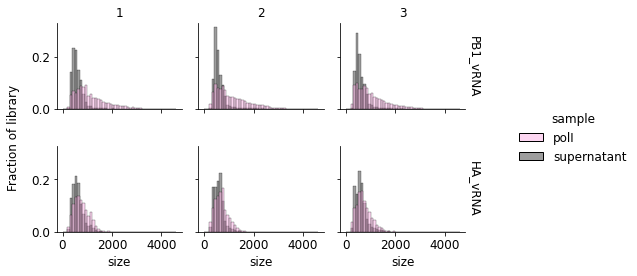

In [64]:

bins = range(0, 4700,binsize)
g = sns.displot(data=pd.concat([polI,sup]), x='size',  col="library", hue='sample', row='segment',
               alpha=0.5, weights = 'fraction', bins= bins, aspect= 1.2, height=2, palette=twoColorPalette,
               facet_kws=dict(row_order=["PB1_vRNA", "HA_vRNA"], col_order=[1,2,3], margin_titles=True))
g.set_titles(col_template="{col_name}", row_template="{row_name}")


g.set_axis_labels("size", " ")

g.fig.text(0.01, 0.5, 'Fraction of library', va='center', rotation='vertical')
plt.savefig('Figures/supernatantPopulationShiftBeginningToEnd.pdf', format='pdf', bbox_inches = "tight")

Again, how is this represented in terms of enrichment?

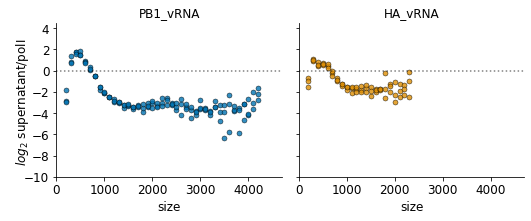

In [67]:
enrich = pd.concat([sup,polI]).pivot_table(index=['segment','size','library'], 
                                   columns=['sample'], values='fraction').reset_index().dropna()

counts = enrich.groupby(['segment', 'size']).count().reset_index()
counts = counts[counts.library == 3][['segment','size']]
enrich = enrich.merge(counts, on=['segment','size'], how='right')
enrich['enrichment'] = np.log2(enrich.supernatant/enrich.polI)


g = sns.lmplot(x="size", y="enrichment", col="segment", col_order=["PB1_vRNA", "HA_vRNA"], hue='segment', palette=fluColors,
               data=enrich, fit_reg=False,aspect=1.2, height=3,scatter_kws={"s":25, "linewidth":0.5,'edgecolor':'k'})
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set(ylabel="")


g.set_titles(col_template="{col_name}", row_template="{row_name}")


g.set_axis_labels("size", " ")

g.fig.text(-0.01, 0.5, '$log_{2}$ supernatant/polI', va='center', rotation='vertical')

g.set(xlim=(0,4700))
g.set(ylim=(-10,4.5))
g.set(yticks=np.arange(-10,5,2))
axes = g.fig.axes
for ax in axes:
    ax.axhline(y=0, color='k', linestyle=':',alpha=0.5)
plt.savefig('Figures/SupernatantEnrichmentBinned.pdf', format='pdf', bbox_inches = "tight")
enrich['library'] = enrich.library.astype(str)
enrich = enrich.pivot_table(index=['size','segment'], columns=['library'], values='enrichment').reset_index().dropna()
plt.savefig('Figures/enrichEndToBEginning.pdf', format='pdf', bbox_inches = "tight")

Pearson calculation for the journey of each individual junction from beginning to end

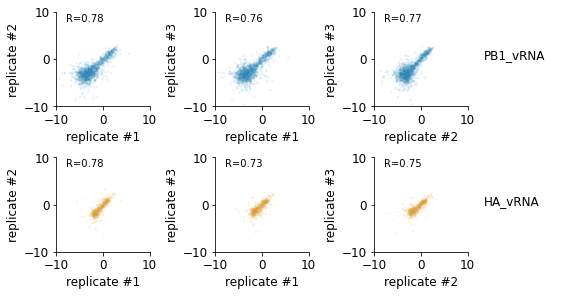

In [66]:
enrichment = sup_individual.merge(polI_individual, on =['segment', 'library','position_UP','position_DOWN','size'], suffixes=['_sup','_polI'])
enrichment['enrichment'] = np.log2(enrichment.fraction_sup/enrichment.fraction_polI)
enrichment['library'] = enrichment.library.astype(str)
enrichment = enrichment.pivot_table(index=['position_UP','position_DOWN','segment'], columns=['library'], values='enrichment').reset_index().dropna().drop(columns=['position_UP','position_DOWN'])
columns = int(math.factorial(replicates)/(2* math.factorial(replicates-2)))
rows = len(set(enrichment.segment))
height = 2
width = 2
g= plt.figure(1,(width*(columns+1),rows*height), constrained_layout=True)

spec = g.add_gridspec(rows,columns +1)
for row, segment in enumerate(['PB1_vRNA','HA_vRNA']):
    numRep = 1
    currCol = 0
    first = False
    pearsonVal = enrichment[enrichment.segment == segment].corr()
    while numRep < replicates:
        comparison = numRep + 1
        
        while comparison <= replicates:
            if not first:
                ax = g.add_subplot(spec[row, currCol])
                firstAx = ax
                first = True
            else:
                ax = g.add_subplot(spec[row,currCol], sharey = firstAx, sharex= firstAx)
                
            sns.scatterplot(data=enrichment[enrichment.segment == segment], x=str(numRep), y=str(comparison), alpha=0.1, hue='segment', palette=fluColors,
                            legend=False, ax=ax, rasterized=True, s=5)
            sns.despine()
            ax.set_ylabel('replicate #' + str(comparison))
            ax.set_xlabel('replicate #' + str(numRep))
            ax.set_ylim(-10,10)
            ax.set_xlim(-10,10)
            Rval = round(pearsonVal[str(numRep)].iloc[comparison-1],2)
            ax.text(0.1, 0.9, 'R=' + str(Rval), transform=ax.transAxes, fontsize = 10)
            comparison += 1
            currCol +=1
        ax = g.add_subplot(spec[row, currCol])
        ax.axis('off')
        ax.text(0.0, 0.5, segment, transform=ax.transAxes, fontsize=12)
        numRep +=1
        
        
plt.savefig('Figures/PearsonBeginningToEnd.pdf', format='pdf', bbox_inches = "tight")

## Interferon selection

Cells were infected at a non-saturating MOI, then harvested at 13hpi and sorted using anti-LNGFR magnetic sorting on interferon. Paired qPCR data graphed elsewhere.

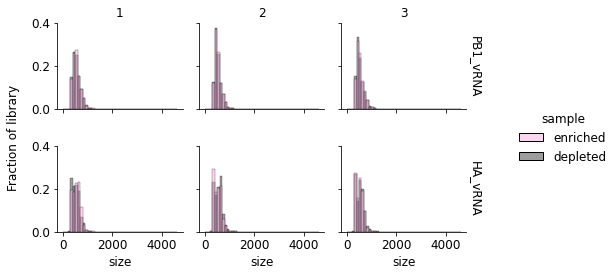

In [68]:
deplete = sequencing['MACS_depleted'].copy()
deplete['size'] = (deplete['size']/binsize).apply(np.ceil) * binsize
deplete = deplete.groupby(['size', 'library', 'segment']).sum().reset_index()[['size', 'segment', 'library', 'count']]
sums = deplete.groupby(['segment','library']).sum().reset_index().rename(columns={'count':'sum'}).drop(columns=['size'])
deplete = deplete.merge(sums, on = ['library', 'segment'] )
deplete['fraction'] = deplete['count']/deplete['sum']
deplete['sample'] = 'depleted'



enriched = sequencing['MACS_enriched'].copy()
enriched['size'] = (enriched['size']/binsize).apply(np.ceil) * binsize
enriched = enriched.groupby(['size',  'library', 'segment']).sum().reset_index()[['size', 'segment', 'library', 'count']]
sums = enriched.groupby(['library', 'segment']).sum().reset_index().rename(columns={'count':'sum'}).drop(columns=['size'])
enriched = enriched.merge(sums, on = ['library', 'segment'] )
enriched['fraction'] = enriched['count']/enriched['sum']
enriched['sample'] = 'enriched'
bins = range(0, 4700,binsize)
g = sns.displot(data=pd.concat([enriched,deplete]), x='size',  col="library", hue='sample', row='segment',
               alpha=0.5, weights = 'fraction', bins= bins, aspect= 1.2, height=2, palette=twoColorPalette,
               facet_kws=dict(row_order=["PB1_vRNA", "HA_vRNA"], col_order=[1,2,3], margin_titles=True))
g.set_titles(col_template="{col_name}", row_template="{row_name}")


g.set_axis_labels("size", " ")
g.set(ylim=(0, 0.4))
g.fig.text(0.01, 0.5, 'Fraction of library', va='center', rotation='vertical')
plt.savefig('Figures/populationShiftInterferon.pdf',  bbox_inches = "tight")

As before, does length make a difference?

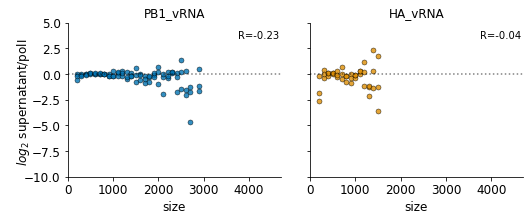

In [71]:
enrich = pd.concat([enriched,deplete]).pivot_table(index=['segment','size','library'], 
                                   columns=['sample'], values='fraction').reset_index().dropna()

counts = enrich.groupby(['segment', 'size']).count().reset_index()
counts = counts[counts.library == 3][['segment','size']]
enrich = enrich.merge(counts, on=['segment','size'], how='right')
enrich['enrichment'] = np.log2(enrich.enriched/enrich.depleted)


g = sns.lmplot(x="size", y="enrichment", col="segment", col_order=["PB1_vRNA", "HA_vRNA"], hue='segment', palette=fluColors,
               data=enrich, fit_reg=False,aspect=1.2, height=3,scatter_kws={"s":25, "linewidth":0.5,'edgecolor':'k'})
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set(ylabel="")


g.set_titles(col_template="{col_name}", row_template="{row_name}")


g.set_axis_labels("size", " ")

g.fig.text(-0.03, 0.5, '$log_{2}$ supernatant/polI', va='center', rotation='vertical')

g.set(xlim=(0,4700))
g.set(ylim=(-10,5))

axes = g.fig.axes
for segment, ax in enumerate(axes):
    ax.axhline(y=0, color='k', linestyle=':',alpha=0.5)
    spearman = round(enrich[enrich.segment == ["PB1_vRNA", "HA_vRNA"][segment]].corr('spearman')['size']['enrichment'],2)
    ax.text(0.8, 0.9, 'R=' + str(spearman), transform=ax.transAxes, fontsize = 10)
plt.savefig('Figures/SupernatantEnrichmentBinned.pdf', format='pdf', bbox_inches = "tight")
enrich['library'] = enrich.library.astype(str)
enrich = enrich.pivot_table(index=['size','segment'], columns=['library'], values='enrichment').reset_index().dropna()
plt.savefig('Figures/interferonvsLength.pdf', format='pdf', bbox_inches = "tight")

Again, calculate Pearson

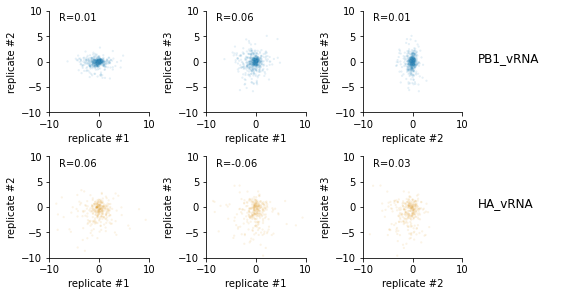

In [51]:
#combine barcodes into the same junction, but keep individual
enriched_individual = sequencing['MACS_enriched'].copy().groupby(['segment','library','position_UP','position_DOWN','size']).sum().reset_index()[['segment','library','position_UP','position_DOWN','count','size']]
depleted_individual = sequencing['MACS_depleted'].copy().groupby(['segment','library','position_UP','position_DOWN','size']).sum().reset_index()[['segment','library','position_UP','position_DOWN','count','size']]
replicates = len(set(depleted_individual.library))

sums = enriched_individual.groupby(['segment','library']).sum().reset_index().rename(columns={'count':'sum'}).drop(columns=['size','position_UP','position_DOWN'])
enriched_individual = enriched_individual.merge(sums, on = ['segment','library'] )
enriched_individual['fraction'] = enriched_individual['count']/enriched_individual['sum']

sums = depleted_individual.groupby(['segment','library']).sum().reset_index().rename(columns={'count':'sum'}).drop(columns=['size','position_UP','position_DOWN'])
depleted_individual = depleted_individual.merge(sums, on = ['segment','library'] )
depleted_individual['fraction'] = depleted_individual['count']/depleted_individual['sum']
#enrichment
enrichment = enriched_individual.merge(depleted_individual, on =['segment', 'library','position_UP','position_DOWN','size'], suffixes=['_enrich','_deplete'])
enrichment['enrichment'] = np.log2(enrichment.fraction_enrich/enrichment.fraction_deplete)
enrichment['library'] = enrichment.library.astype(str)
enrichment = enrichment.pivot_table(index=['position_UP','position_DOWN','segment'], columns=['library'], values='enrichment').reset_index().dropna().drop(columns=['position_UP','position_DOWN'])
columns = int(math.factorial(replicates)/(2* math.factorial(replicates-2)))
rows = len(set(enrichment.segment))
height = 2
width = 2
g= plt.figure(1,(width*(columns+1),rows*height), constrained_layout=True)

spec = g.add_gridspec(rows,columns +1)
for row, segment in enumerate(['PB1_vRNA','HA_vRNA']):
    numRep = 1
    currCol = 0
    first = False
    pearsonVal = enrichment[enrichment.segment == segment].corr()
    while numRep < replicates:
        comparison = numRep + 1
        
        while comparison <= replicates:
            if not first:
                ax = g.add_subplot(spec[row, currCol])
                firstAx = ax
                first = True
            else:
                ax = g.add_subplot(spec[row,currCol], sharey = firstAx, sharex= firstAx)
                
            sns.scatterplot(data=enrichment[enrichment.segment == segment], x=str(numRep), y=str(comparison),alpha=0.1, hue='segment', palette=fluColors,
                            legend=False, ax=ax, rasterized=True, s=5)
            sns.despine()
            ax.set_ylabel('replicate #' + str(comparison))
            ax.set_xlabel('replicate #' + str(numRep))
            ax.set_ylim(-10,10)
            ax.set_xlim(-10,10)
            Rval = round(pearsonVal[str(numRep)].iloc[comparison-1],2)
            ax.text(0.1, 0.9, 'R=' + str(Rval), transform=ax.transAxes, fontsize = 10)
            comparison += 1
            currCol +=1
        ax = g.add_subplot(spec[row, currCol])
        ax.axis('off')
        ax.text(0.0, 0.5, segment, transform=ax.transAxes, fontsize=12)
        numRep +=1
        
        
plt.savefig('Figures/interferonPearson.pdf', format='pdf', bbox_inches = "tight")

Is this largely a function of poor enrichment of any deletions? Look to see how well absolute counts vary.

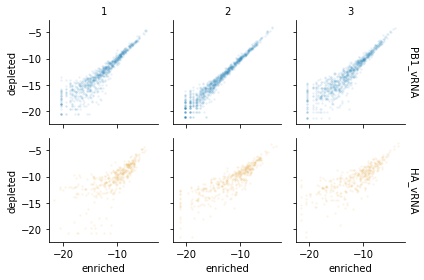

In [52]:
depleted_individual['sample'] = 'depleted'
enriched_individual['sample'] = 'enriched'

overall = pd.concat([depleted_individual, enriched_individual]).pivot_table(index=['position_UP', 'position_DOWN','library', 'segment'], 
                                                                                columns=['sample'], values='fraction').reset_index().dropna()

overall['enriched'] = np.log2(overall.enriched)
overall['depleted'] = np.log2(overall.depleted)

g = sns.FacetGrid(overall, row="segment", col="library", margin_titles=True, height=2, hue='segment', palette=fluColors,
                 row_order=["PB1_vRNA", "HA_vRNA"])
g.map(sns.scatterplot, "enriched", "depleted", alpha=0.1, rasterized=True,s=5)



g.set_titles(col_template="{col_name}", row_template="{row_name}")
plt.savefig('Figures/interferonCorrelation.pdf', format='pdf', bbox_inches = "tight")

Most effects low to non-existant. Instead analyze data using the DESeq2 framework to see if any individual junctions produce signal above noise.

In [35]:
outDir = 'Results/barcode'
if not os.path.isdir(outDir):
    os.mkdir(outDir)
for segment in ['HA_vRNA','PB1_vRNA']:
    
    enrich = sequencing['MACS_enriched'][sequencing['MACS_enriched'].segment == segment].copy()
    enrich = enrich.groupby(['segment', 'size', 'position_UP', 'position_DOWN','library']).sum().reset_index()
    enrich['deletion_name'] = enrich.segment + '_' + enrich.position_UP.astype(str) + ':' + enrich.position_DOWN.astype(str)
    enrich = enrich.pivot(index='deletion_name', columns='library', values = 'count').reset_index().fillna(0)
    deplete = sequencing['MACS_depleted'][sequencing['MACS_depleted'].segment == segment].copy()
    deplete = deplete.groupby(['segment',  'size', 'position_UP', 'position_DOWN','library']).sum().reset_index()
    deplete['deletion_name'] = deplete.segment + '_' + deplete.position_UP.astype(str) + ':' + deplete.position_DOWN.astype(str)
    deplete = deplete.pivot(index='deletion_name', columns='library', values = 'count').reset_index().fillna(0)
    merged = enrich.merge(deplete, on='deletion_name', how='outer', suffixes=['_enriched', '_depleted']).fillna(0)
    for library in ['1','2','3']:
        for sort in ['enriched', 'depleted']:
            merged[['deletion_name',library + '_' + sort]].to_csv(outDir + '/' + segment + '-Library-' + library + '_' + sort + '_DESeqCount.tsv', sep='\t', header=False, index=False)

DESeq2 results. Noted points validated

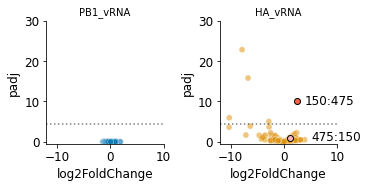

In [74]:
DESeq2Frame = []
for file in glob.glob('Results/barcode/*_DESeq2.tsv'):
    DESeq2Frame += [pd.read_csv(file, sep='\t').rename(columns={'Unnamed: 0':'name'})]
DESeq2Frame = pd.concat(DESeq2Frame).dropna()
DESeq2Frame['padj'] = -np.log2(DESeq2Frame.padj)
DESeq2Frame['segment'] = DESeq2Frame.name.str.split('_').str[0:2].str.join('_')
g= plt.figure(1,(5,2.5), constrained_layout=True)
#remove low-abundance, messy points
DESeq2Frame = DESeq2Frame[DESeq2Frame.baseMean > 100]
spec = g.add_gridspec(1,2)
for col, segment in enumerate(['PB1_vRNA','HA_vRNA']):
    ax = g.add_subplot(spec[0, col])
    sns.scatterplot(data=DESeq2Frame[DESeq2Frame.segment == segment], x='log2FoldChange', y='padj', alpha=0.5, hue='segment', palette=fluColors,
                            legend=False, ax=ax, rasterized=True)
    if segment == 'HA_vRNA':
        sns.scatterplot(data=DESeq2Frame[DESeq2Frame.name == 'HA_vRNA_150.0:475.0'], x="log2FoldChange", y='padj', ax =ax, color='tomato',edgecolor="black",  linewidth=1)
        ax.text(DESeq2Frame[DESeq2Frame.name == 'HA_vRNA_150.0:475.0'].log2FoldChange.iloc[0] +1.5,
               DESeq2Frame[DESeq2Frame.name == 'HA_vRNA_150.0:475.0'].padj.iloc[0]-0.75, '150:475', size='medium', color='black',horizontalalignment='left')
        sns.scatterplot(data=DESeq2Frame[DESeq2Frame.name == 'HA_vRNA_475.0:150.0'], x="log2FoldChange", y='padj', ax =ax, color='lightpink',edgecolor="black", linewidth=1)
        ax.text(DESeq2Frame[DESeq2Frame.name == 'HA_vRNA_475.0:150.0'].log2FoldChange.iloc[0] +4,
               DESeq2Frame[DESeq2Frame.name == 'HA_vRNA_475.0:150.0'].padj.iloc[0]-0.75, '475:150', size='medium', color='black',horizontalalignment='left')
    ax.set_xlim(-12,10)
    ax.set_ylim(-.5,30)
    
    ax.set_title(segment, fontsize=10)
    sns.despine()
    ax.axhline(y=-np.log2(0.05),color='k', linestyle=':',alpha=0.5)


plt.savefig('Figures/DESeq2Graph.pdf', format='pdf', bbox_inches = "tight", dpi=1000)